In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import warnings
import seaborn as sns
import matplotlib.dates as mdates
import yfinance as yf
from tqdm import tqdm
warnings.filterwarnings('ignore')
from xgboost import XGBRegressor

plt.style.use("dark_background")

In [2]:
from fredapi import Fred

def download(codes):
    key=''
    fred = Fred(api_key=key)
    data={}
    for i in codes.values():
        data[i]=fred.get_series(i)
    macro=pd.DataFrame.from_dict(data)
    
    return macro


In [3]:
codes={'Corporate': 'BAA10Y','10Y':'DGS10','1Y': 'DGS1'}
macro=download(codes).resample('MS').ffill()
macro.columns=list(codes.keys())

macro['Time']=((macro['10Y']-macro['1Y'])/((macro['10Y']).expanding().mean()))*100
macro['Confidence']=((macro['10Y']-macro['Corporate'])/((macro['10Y']).expanding().mean()))*100
macro=macro.resample('MS').ffill().dropna()
macro

,Corporate,10Y,1Y,Time,Confidence
1986-02-01,2.29,9.08,7.57,19.436258,87.398805
1986-03-01,2.49,8.13,7.43,9.008618,72.583724
1986-04-01,2.91,7.37,6.70,8.624193,57.408804
1986-05-01,2.73,7.45,6.55,11.586504,60.764776
1986-06-01,2.36,8.05,6.88,15.060428,73.242593
...,...,...,...,...,...
2022-06-01,2.08,2.94,2.16,13.184744,14.537026
2022-07-01,2.42,2.88,2.79,1.522485,7.781588
2022-08-01,2.38,2.60,2.98,-6.433647,3.724743
2022-09-01,2.22,3.26,3.51,-4.235491,17.619642


In [4]:
def bond_tr(y,m,k=(1/252)):
    z=1+y*0.5
    duration=(1-1/(z**(2*m)))/y
    convexity=(2/(y**2))*(1-1/(z**(2*m)))-(2*m)/(y*(z)**(2*m))
    b_rets=(1+y)**(1/252)-1-duration*(y-y.shift(1))+0.5*convexity*((y-y.shift(1))**2)
    return (1+b_rets).cumprod()

In [5]:
assets={'Gold': '^XAU','US 10y bonds':'^TNX','US 5y bonds': '^FVX','S&P500':'^GSPC','Commodities':'^SPGSCI','US 13wk bonds':'^IRX'}
assets=dict(sorted(assets.items(), key=lambda item: item[1]))
data_=yf.download(list(assets.values()))['Adj Close'].dropna()

[*********************100%***********************]  6 of 6 completed


<AxesSubplot:xlabel='Date'>

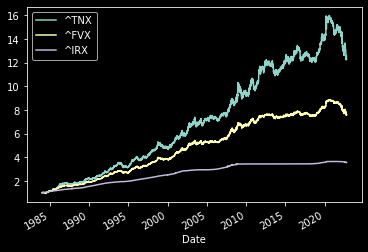

In [6]:
data_['^TNX']=bond_tr(data_['^TNX']/100,10)
data_['^FVX']=bond_tr(data_['^FVX']/100,5)
data_['^IRX']=bond_tr(data_['^IRX']/100,1,k=(91/252))

data_[['^TNX','^FVX','^IRX']].plot()

In [7]:
forecast_windows=1

In [15]:
all={}
for i in assets.values():
    macro_=macro.iloc[:,-3:].join(data_[i].resample('MS').ffill())
    macro_.columns=list(macro.iloc[:,-3:].columns)+[i]
    macro_['52avg']=(macro_[i]/macro_[i].rolling(52).mean()-1)*100
    macro_['4avg']=(macro_[i]/macro_[i].rolling(4).mean()-1)*100
    macro_['12avg']=(macro_[i]/macro_[i].rolling(12).mean()-1)*100
    macro_['y']=macro_[i].shift(-forecast_windows)
    all[i]=macro_

In [17]:
def deploy(X,y,roll):
    predicted=[]
    for i in range(roll+forecast_windows,len(X)):
        model = XGBRegressor(**param)
        X_fit = X.iloc[i-roll-forecast_windows:i-forecast_windows]
        y_fit = y.iloc[i-roll-forecast_windows:i-forecast_windows]

        model = model.fit(X_fit, y_fit)

        X_predict = X.iloc[i:i+ 1]
        y_pred = model.predict(X_predict)
        
        predicted.append(y_pred)

    predicted_df=pd.DataFrame(predicted,index=X.iloc[forecast_windows+roll:].index)
    predicted_df['Actual']=X.iloc[:,3]
    return predicted_df

In [18]:
split_date='1992-01-01'
roll=4
preds={}
param={'random_state': 100,
 'lambda': 1,
 'max_depth': 3,
 'n_estimators': 50,
 'eta': 0.3}

 
for i in tqdm(all.keys()):
    df=all[i]
    split_date=df[df.index < split_date].index[-1]
    df=df.loc[split_date:]
    preds[i]=deploy(df.iloc[:,:-1],df.iloc[:,-1],roll)

100%|██████████| 6/6 [00:33<00:00,  5.51s/it]


In [20]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import max_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_absolute_percentage_error
def stats(y_actual,y_pred):
    print('R2: ', "{:.2%}".format(explained_variance_score(y_actual,y_pred)))
    print('Mean Abs Error: ', "{:.5}".format(mean_absolute_error(y_actual,y_pred)))
    print('RMSE: ', "{:.5}".format(mean_squared_error(y_actual,y_pred,squared=False)))
    print('Max Error: ', "{:.5}".format(max_error(y_actual,y_pred)))
    print('MAPE: ', "{:.2%}".format(mean_absolute_percentage_error(y_actual,y_pred)))

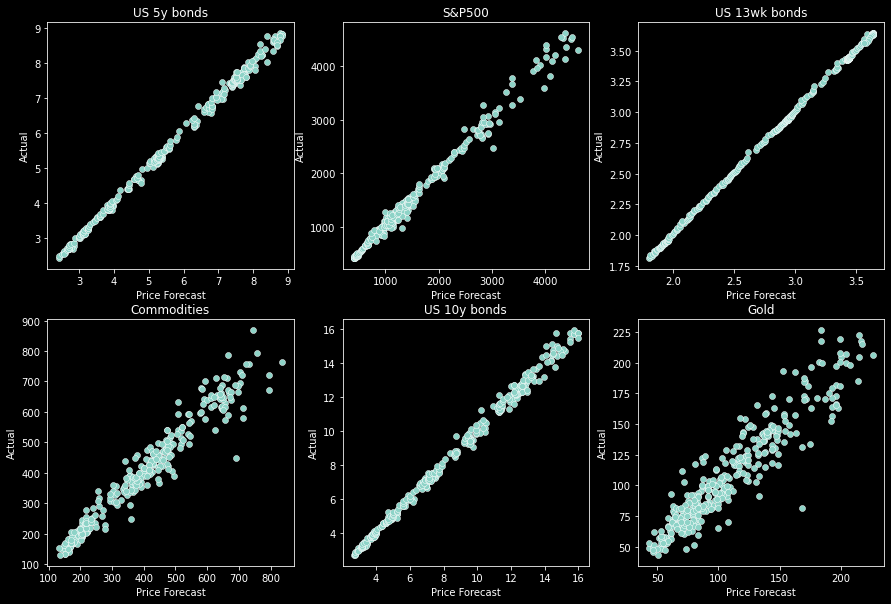

In [21]:
a=0
fig = plt.figure(figsize=(15, 10))

for i in assets.values():
    ax = fig.add_subplot(2,3,a+1)
    ax.set_xlabel('Price Forecast')
    sns.scatterplot(x=preds[i].iloc[:,0],y=preds[i].iloc[:,1],ax=ax)
    plt.title(str(list(assets.keys())[a]))
    a+=1
plt.show()

In [22]:
rets={}
for i in assets.values():
    rets[i]=pd.concat([(preds[i][0]/preds[i]['Actual'].shift(4)-1),(preds[i]['Actual']/(preds[i]['Actual'].shift(4))-1)],axis=1).dropna()

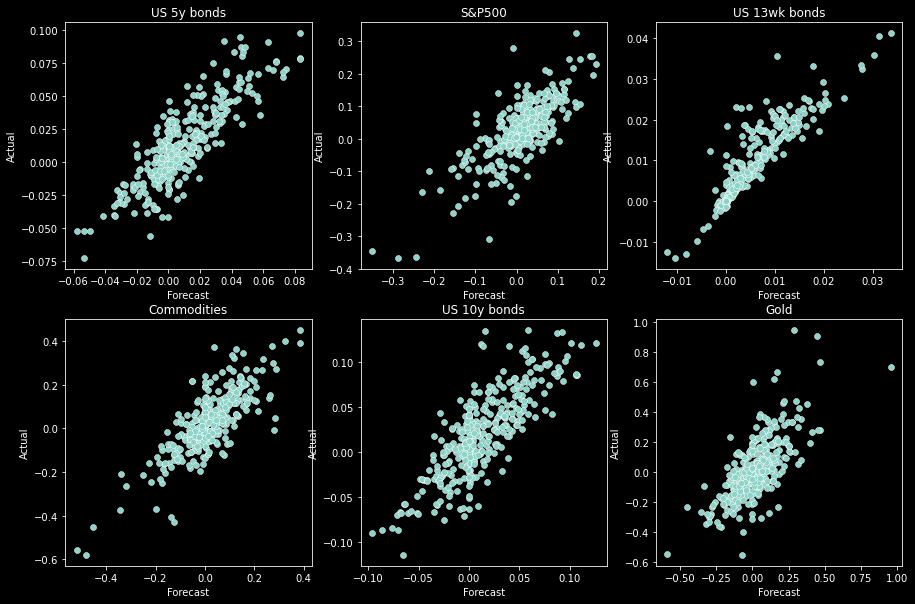

In [23]:
b=0
returns={}
fig = plt.figure(figsize=(15, 10))
for i in assets.values():
    ax = fig.add_subplot(2,3,b+1)
    ax.set_xlabel('Forecast')
    sns.scatterplot(x=rets[i].iloc[:,0],y=rets[i].iloc[:,1],ax=ax)
    plt.title(str(list(assets.keys())[b]))
    returns[i]=pd
    b+=1
plt.show()

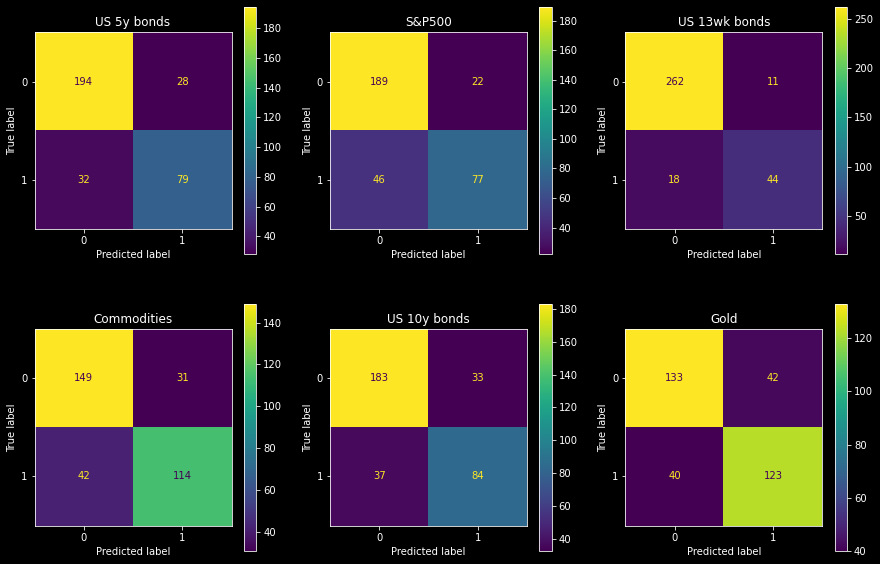

In [24]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
b=0
fig = plt.figure(figsize=(15, 10))
for i in assets.values():
    ax = fig.add_subplot(2,3,b+1)
    cm = confusion_matrix(pd.get_dummies(rets[i].iloc[:,0]>0).iloc[:,0], pd.get_dummies(rets[i].iloc[:,1]>0).iloc[:,0])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=ax)
    plt.title(str(list(assets.keys())[b]))
    b+=1
plt.show()

In [25]:
returns=data_.pct_change().dropna()

In [26]:
d = { k: v[0] for k, v in rets.items()}
d=pd.concat(d, axis=1).dropna()
returns.columns=list(assets.keys())
returns=returns.join(d.resample('D').ffill()).dropna()
returns.tail()

,US 5y bonds,S&P500,US 13wk bonds,Commodities,US 10y bonds,Gold,^FVX,^GSPC,^IRX,^SPGSCI,^TNX,^XAU
Date,,,,,,,,,,,,
2022-09-26,-0.007636,-0.010341,-0.000433,-0.020451,-0.014615,-0.025690,0.019022,-0.070003,-0.010352,-0.11241,0.033125,-0.242837
2022-09-27,-0.002112,-0.002120,-0.000703,0.011938,-0.006862,0.007221,0.019022,-0.070003,-0.010352,-0.11241,0.033125,-0.242837
2022-09-28,0.013195,0.019672,0.000321,0.029317,0.021871,0.066370,0.019022,-0.070003,-0.010352,-0.11241,0.033125,-0.242837
2022-09-29,-0.002403,-0.021126,0.000243,-0.004591,-0.003324,0.012020,0.019022,-0.070003,-0.010352,-0.11241,0.033125,-0.242837
2022-09-30,-0.002621,-0.015067,0.000495,-0.013040,-0.004544,0.015702,0.019022,-0.070003,-0.010352,-0.11241,0.033125,-0.242837


In [27]:
d.columns=assets.values()
d.to_csv('predictions.csv')